In [ ]:
# ===============================
# ⚡ HIGH SPEED TRAINING (GPU Optimized)
# EfficientNet-B0 + Mixed Precision + Validation
# ===============================

import os, shutil
import numpy as np, pandas as pd
from PIL import Image
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.model_selection import train_test_split

torch.backends.cudnn.benchmark = True   # ⚡ Enable fastest GPU performance

# ===============================
# Paths (Already Correct)
# ===============================
image_dirs = [
    "/content/drive/MyDrive/HAM10000_Project/HAM10000_images_part_1",
    "/content/drive/MyDrive/HAM10000_Project/HAM10000_images_part_2"
]
metadata_path = "/content/drive/MyDrive/HAM10000_Project/HAM10000_metadata.csv"
model_save_path = "/content/drive/MyDrive/HAM10000_Project/final_effnet_fast.pth"

# ===============================
# Load Images
# ===============================
image_dir = "/content/HAM10000_images"
os.makedirs(image_dir, exist_ok=True)

for folder in image_dirs:
    for file in os.listdir(folder):
        if file.endswith(".jpg"):
            shutil.copy(os.path.join(folder, file), os.path.join(image_dir, file))

# ===============================
# Load Metadata
# ===============================
metadata = pd.read_csv(metadata_path)
metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
metadata = metadata[metadata['image_path'].apply(os.path.exists)].reset_index(drop=True)

label2idx = {label: idx for idx, label in enumerate(metadata['dx'].unique())}
metadata['label'] = metadata['dx'].map(label2idx)
num_classes = len(label2idx)

# ===============================
# Train/Validation Split
# ===============================
train_df, val_df = train_test_split(metadata, test_size=0.15, stratify=metadata['label'], random_state=42)

# ===============================
# Dataset Class
# ===============================
class SkinDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img = Image.open(self.df.loc[idx, 'image_path']).convert('RGB')
        label = self.df.loc[idx, 'label']
        if self.transform: img = self.transform(img)
        return img, label

# ===============================
# 🔥 Fast Optimized Transforms
# ===============================
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_loader = DataLoader(SkinDataset(train_df, train_tf), batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(SkinDataset(val_df, val_tf), batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# ===============================
# Model Setup
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

# ===============================
# 🚀 Training with Validation
# ===============================
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(imgs)  # FIXED: removed extra 'a'
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_loss = running_loss / total

    # ===== Validation =====
    model.eval()
    val_correct, val_total, val_loss_run = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            val_loss_run += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss_run / val_total

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2f}% | Train Loss: {train_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}% | Val Loss: {val_loss:.4f}")

torch.save(model.state_dict(), model_save_path)
print(f"🚀 Fast Training Finished & Model Saved: {model_save_path}")


Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Using: cuda
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 166MB/s]
/tmp/ipython-input-980827535.py:107: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/20:   0%|          | 0/133 [00:00<?, ?it/s]/tmp/ipython-input-980827535.py:123: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/20: 100%|██████████| 133/133 [02:16<00:00,  1.03s/it]
/tmp/ipython-input-980827535.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Train Acc: 72.24% | Train Loss: 1.0587 | Val Acc: 81.84% | Val Loss: 0.8512


Epoch 2/20: 100%|██████████| 133/133 [01:23<00:00,  1.59it/s]


Epoch 2 | Train Acc: 80.73% | Train Loss: 0.8623 | Val Acc: 83.70% | Val Loss: 0.8089


Epoch 3/20: 100%|██████████| 133/133 [01:22<00:00,  1.61it/s]


Epoch 3 | Train Acc: 82.88% | Train Loss: 0.8127 | Val Acc: 83.30% | Val Loss: 0.7828


Epoch 4/20: 100%|██████████| 133/133 [01:24<00:00,  1.58it/s]


Epoch 4 | Train Acc: 85.01% | Train Loss: 0.7704 | Val Acc: 84.03% | Val Loss: 0.8154


Epoch 5/20: 100%|██████████| 133/133 [01:22<00:00,  1.61it/s]


Epoch 5 | Train Acc: 86.82% | Train Loss: 0.7406 | Val Acc: 85.23% | Val Loss: 0.7654


Epoch 6/20: 100%|██████████| 133/133 [01:23<00:00,  1.59it/s]


Epoch 6 | Train Acc: 87.45% | Train Loss: 0.7133 | Val Acc: 87.89% | Val Loss: 0.7349


Epoch 7/20: 100%|██████████| 133/133 [01:22<00:00,  1.61it/s]


Epoch 7 | Train Acc: 87.89% | Train Loss: 0.7082 | Val Acc: 86.49% | Val Loss: 0.7611


Epoch 8/20: 100%|██████████| 133/133 [01:22<00:00,  1.60it/s]


Epoch 8 | Train Acc: 89.67% | Train Loss: 0.6779 | Val Acc: 87.23% | Val Loss: 0.7363


Epoch 9/20: 100%|██████████| 133/133 [01:23<00:00,  1.58it/s]


Epoch 9 | Train Acc: 89.64% | Train Loss: 0.6667 | Val Acc: 88.09% | Val Loss: 0.7211


Epoch 10/20: 100%|██████████| 133/133 [01:24<00:00,  1.57it/s]


Epoch 10 | Train Acc: 91.07% | Train Loss: 0.6524 | Val Acc: 88.29% | Val Loss: 0.7346


Epoch 11/20: 100%|██████████| 133/133 [01:24<00:00,  1.57it/s]


Epoch 11 | Train Acc: 91.34% | Train Loss: 0.6445 | Val Acc: 88.69% | Val Loss: 0.7093


Epoch 12/20: 100%|██████████| 133/133 [01:22<00:00,  1.61it/s]


Epoch 12 | Train Acc: 91.20% | Train Loss: 0.6390 | Val Acc: 89.62% | Val Loss: 0.7148


Epoch 13/20: 100%|██████████| 133/133 [01:23<00:00,  1.60it/s]


Epoch 13 | Train Acc: 92.00% | Train Loss: 0.6291 | Val Acc: 87.56% | Val Loss: 0.7484


Epoch 14/20: 100%|██████████| 133/133 [01:22<00:00,  1.62it/s]


Epoch 14 | Train Acc: 92.82% | Train Loss: 0.6100 | Val Acc: 88.96% | Val Loss: 0.7140


Epoch 15/20: 100%|██████████| 133/133 [01:23<00:00,  1.59it/s]


Epoch 15 | Train Acc: 93.16% | Train Loss: 0.6033 | Val Acc: 88.62% | Val Loss: 0.7219


Epoch 16/20: 100%|██████████| 133/133 [01:24<00:00,  1.57it/s]


Epoch 16 | Train Acc: 93.48% | Train Loss: 0.5963 | Val Acc: 88.42% | Val Loss: 0.7262


Epoch 17/20: 100%|██████████| 133/133 [01:23<00:00,  1.58it/s]


Epoch 17 | Train Acc: 93.23% | Train Loss: 0.6012 | Val Acc: 88.22% | Val Loss: 0.7409


Epoch 18/20: 100%|██████████| 133/133 [01:24<00:00,  1.58it/s]


Epoch 18 | Train Acc: 93.41% | Train Loss: 0.5960 | Val Acc: 87.62% | Val Loss: 0.7202


Epoch 19/20: 100%|██████████| 133/133 [01:21<00:00,  1.64it/s]


Epoch 19 | Train Acc: 94.22% | Train Loss: 0.5855 | Val Acc: 89.16% | Val Loss: 0.7082


Epoch 20/20: 100%|██████████| 133/133 [01:23<00:00,  1.59it/s]


Epoch 20 | Train Acc: 94.49% | Train Loss: 0.5766 | Val Acc: 88.42% | Val Loss: 0.7343
🚀 Fast Training Finished & Model Saved: /content/drive/MyDrive/HAM10000_Project/final_effnet_fast.pth


Mounted at /content/drive
✅ Total images in folder: 10072
✅ Number of images used: 10015 | Number of classes: 7
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 145MB/s]
100%|██████████| 157/157 [01:24<00:00,  1.86it/s]



📋 Classification Report:

              precision    recall  f1-score   support

         bkl       0.98      0.88      0.92      1099
          nv       0.97      0.99      0.98      6705
          df       0.95      0.91      0.93       115
         mel       0.92      0.90      0.91      1113
        vasc       0.99      0.98      0.98       142
         bcc       0.95      0.95      0.95       514
       akiec       0.97      0.87      0.91       327

    accuracy                           0.96     10015
   macro avg       0.96      0.92      0.94     10015
weighted avg       0.96      0.96      0.96     10015


Overall Accuracy: 96.24%


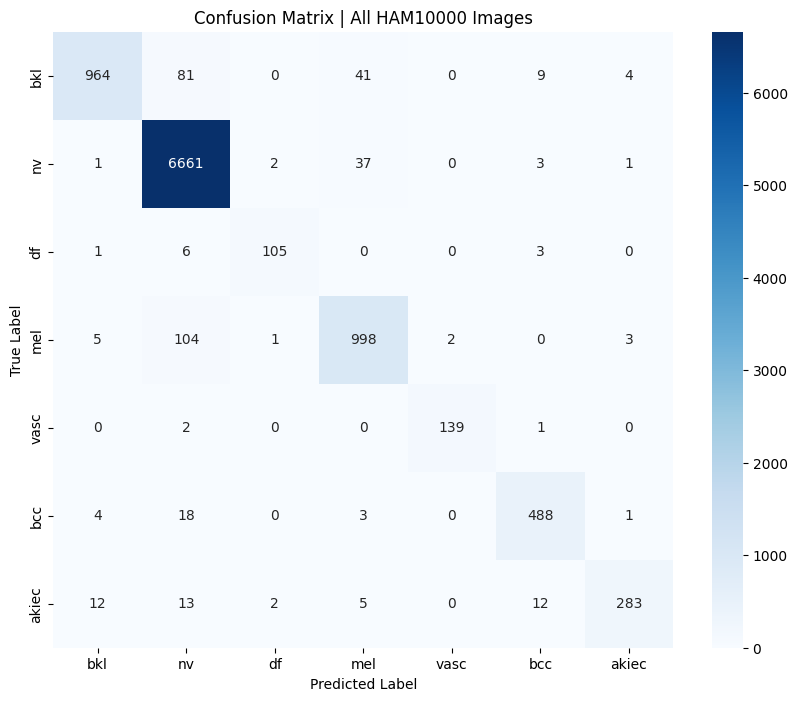

In [ ]:
import os, shutil, glob
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# -------------------------------
# Mount Drive
# -------------------------------
from google.colab import drive
drive.mount('/content/drive')

# -------------------------------
# Paths
# -------------------------------
image_dirs = [
    "/content/drive/MyDrive/HAM10000_Project/HAM10000_images_part_1",
    "/content/drive/MyDrive/HAM10000_Project/HAM10000_images_part_2"
]
image_dir = "/content/HAM10000_images"   # unified folder
metadata_path = "/content/drive/MyDrive/HAM10000_Project/HAM10000_metadata.csv"
model_save_path = "/content/drive/MyDrive/HAM10000_Project/final_effnet_fast.pth"

os.makedirs(image_dir, exist_ok=True)

# -------------------------------
# Copy all images to single folder
# -------------------------------
for folder in image_dirs:
    for file in os.listdir(folder):
        if file.endswith(".jpg"):
            shutil.copy(os.path.join(folder, file), os.path.join(image_dir, file))

# Verify total images
all_files = glob.glob(f"{image_dir}/*.jpg")
print(f"✅ Total images in folder: {len(all_files)}")  # should be ~10015

# -------------------------------
# Load Metadata
# -------------------------------
metadata = pd.read_csv(metadata_path)
metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
metadata = metadata[metadata['image_path'].apply(os.path.exists)].reset_index(drop=True)

label2idx = {label: idx for idx, label in enumerate(metadata['dx'].unique())}
idx2label = {v: k for k, v in label2idx.items()}
metadata['label'] = metadata['dx'].map(label2idx)
num_classes = len(label2idx)

print(f"✅ Number of images used: {len(metadata)} | Number of classes: {num_classes}")

# -------------------------------
# Dataset
# -------------------------------
class FullDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img = Image.open(self.df.loc[idx, 'image_path']).convert('RGB')
        label = self.df.loc[idx, 'label']
        if self.transform: img = self.transform(img)
        return img, label

eval_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

full_loader = DataLoader(
    FullDataset(metadata, eval_tf),
    batch_size=64,
    shuffle=False,
    num_workers=2
)

# -------------------------------
# Load Model
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model.eval()

# -------------------------------
# Evaluation
# -------------------------------
all_labels, all_probs = [], []

with torch.no_grad():
    for imgs, labels in tqdm(full_loader):
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.numpy())

all_labels = np.concatenate(all_labels, axis=0)
all_probs = np.concatenate(all_probs, axis=0)
all_preds = np.argmax(all_probs, axis=1)

# -------------------------------
# Classification Report
# -------------------------------
print("\n📋 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=label2idx.keys()))
print(f"\nOverall Accuracy: {accuracy_score(all_labels, all_preds) * 100:.2f}%")

# -------------------------------
# Confusion Matrix
# -------------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label2idx.keys(),
            yticklabels=label2idx.keys())
plt.title("Confusion Matrix | All HAM10000 Images")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


Mounted at /content/drive
✅ Total images in folder: 10072
✅ Number of images used: 10015
✅ Number of classes: 7


100%|██████████| 157/157 [22:30<00:00,  8.60s/it]



📋 Classification Report:

              precision    recall  f1-score   support

         bkl       0.98      0.88      0.92      1099
          nv       0.97      0.99      0.98      6705
          df       0.95      0.91      0.93       115
         mel       0.92      0.90      0.91      1113
        vasc       0.99      0.98      0.98       142
         bcc       0.95      0.95      0.95       514
       akiec       0.97      0.87      0.91       327

    accuracy                           0.96     10015
   macro avg       0.96      0.92      0.94     10015
weighted avg       0.96      0.96      0.96     10015


Overall Accuracy: 96.24%


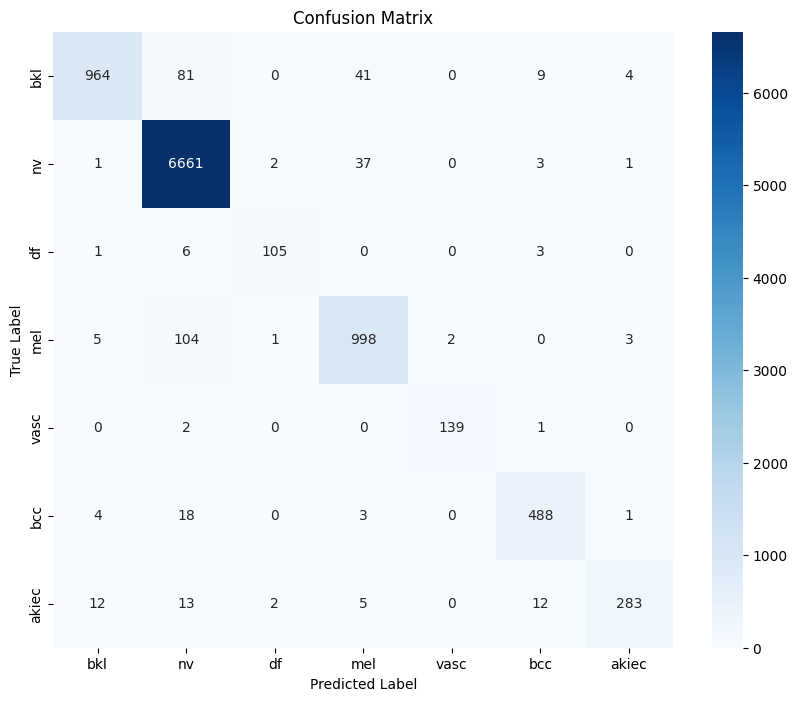

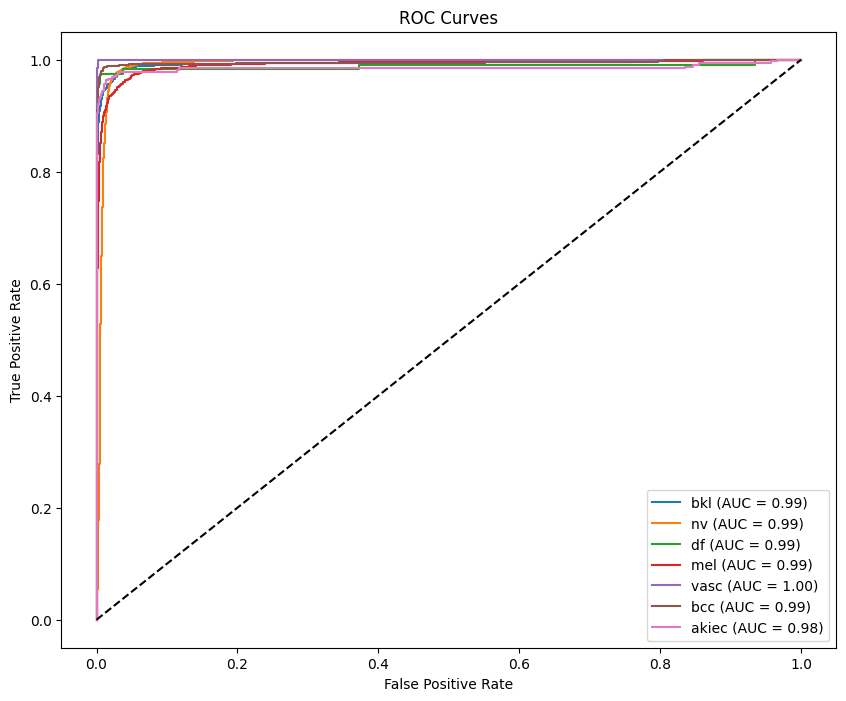

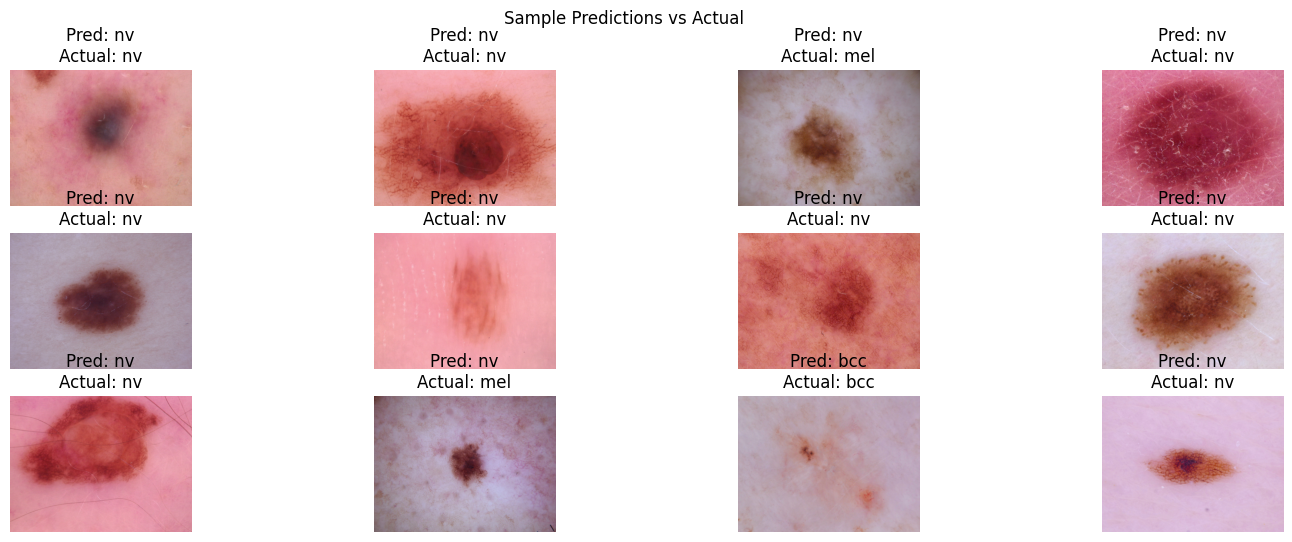

In [ ]:
# ===============================
# 📌 FULL EVALUATION + CURVES + ROC + SAMPLE PREDICTIONS
# ===============================

import os, glob, shutil
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# -------------------------------
# Mount Drive
# -------------------------------
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# -------------------------------
# Paths
# -------------------------------
image_dirs = [
    "/content/drive/MyDrive/HAM10000_Project/HAM10000_images_part_1",
    "/content/drive/MyDrive/HAM10000_Project/HAM10000_images_part_2"
]
image_dir = "/content/HAM10000_images"
metadata_path = "/content/drive/MyDrive/HAM10000_Project/HAM10000_metadata.csv"
model_save_path = "/content/drive/MyDrive/HAM10000_Project/final_effnet_fast.pth"

os.makedirs(image_dir, exist_ok=True)

# -------------------------------
# Copy all images to single folder if not already
# -------------------------------
for folder in image_dirs:
    for file in os.listdir(folder):
        if file.endswith(".jpg"):
            dst = os.path.join(image_dir, file)
            if not os.path.exists(dst):
                shutil.copy(os.path.join(folder, file), dst)

# Verify
all_files = glob.glob(f"{image_dir}/*.jpg")
print(f"✅ Total images in folder: {len(all_files)}")

# -------------------------------
# Load Metadata
# -------------------------------
metadata = pd.read_csv(metadata_path)
metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
metadata = metadata[metadata['image_path'].apply(os.path.exists)].reset_index(drop=True)
print(f"✅ Number of images used: {len(metadata)}")

# Label mappings
label2idx = {label: idx for idx, label in enumerate(metadata['dx'].unique())}
idx2label = {v: k for k, v in label2idx.items()}
metadata['label'] = metadata['dx'].map(label2idx)
num_classes = len(label2idx)
print(f"✅ Number of classes: {num_classes}")

# -------------------------------
# Dataset
# -------------------------------
class EvalDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img = Image.open(self.df.loc[idx, 'image_path']).convert('RGB')
        label = self.df.loc[idx, 'label']
        if self.transform: img = self.transform(img)
        return img, label

eval_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

eval_loader = DataLoader(
    EvalDataset(metadata, eval_tf),
    batch_size=64,
    shuffle=False,
    num_workers=2
)

# -------------------------------
# Load Model
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model.eval()

# -------------------------------
# Predict & Evaluate
# -------------------------------
all_labels, all_probs = [], []

with torch.no_grad():
    for imgs, labels in tqdm(eval_loader):
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.numpy())

all_labels = np.concatenate(all_labels, axis=0)
all_probs = np.concatenate(all_probs, axis=0)
all_preds = np.argmax(all_probs, axis=1)

# -------------------------------
# Classification Report & Accuracy
# -------------------------------
print("\n📋 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=label2idx.keys()))
print(f"\nOverall Accuracy: {accuracy_score(all_labels, all_preds)*100:.2f}%")

# -------------------------------
# Confusion Matrix
# -------------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label2idx.keys(),
            yticklabels=label2idx.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# -------------------------------
# ROC Curves for each class
# -------------------------------
all_labels_bin = label_binarize(all_labels, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{idx2label[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# -------------------------------
# Sample Predictions vs Actual
# -------------------------------
n_samples = 12
sample_df = metadata.sample(n_samples).reset_index(drop=True)

plt.figure(figsize=(18,6))
for i, row in enumerate(sample_df.itertuples()):
    img = Image.open(row.image_path).convert('RGB')
    img_t = eval_tf(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_t)
        pred_idx = output.argmax(1).item()

    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(f"Pred: {idx2label[pred_idx]}\nActual: {idx2label[row.label]}")
    plt.axis('off')
plt.suptitle("Sample Predictions vs Actual")
plt.show()


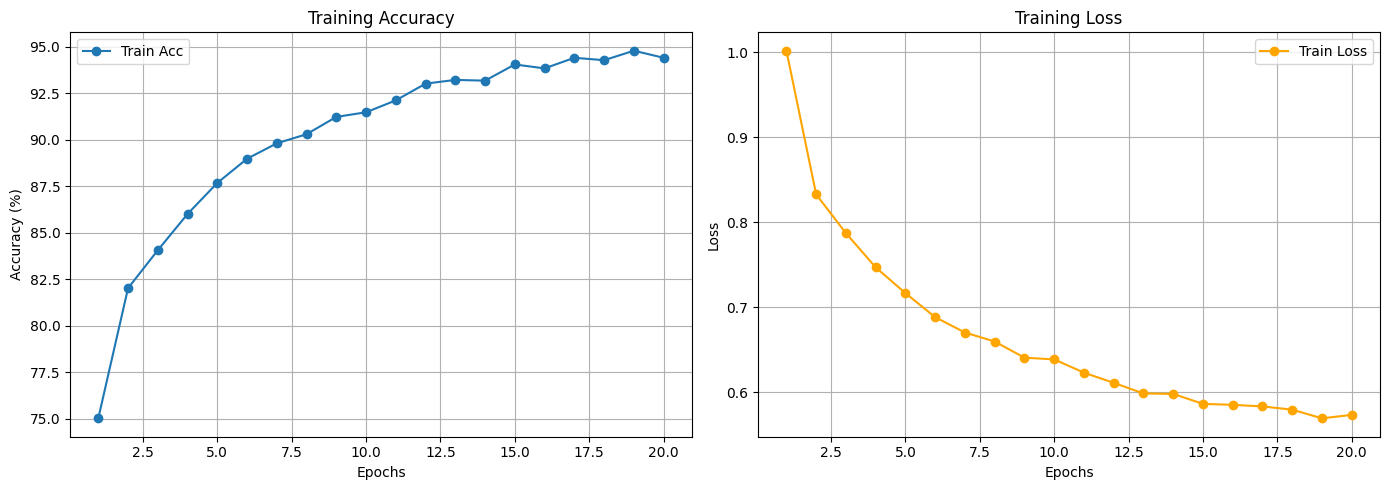

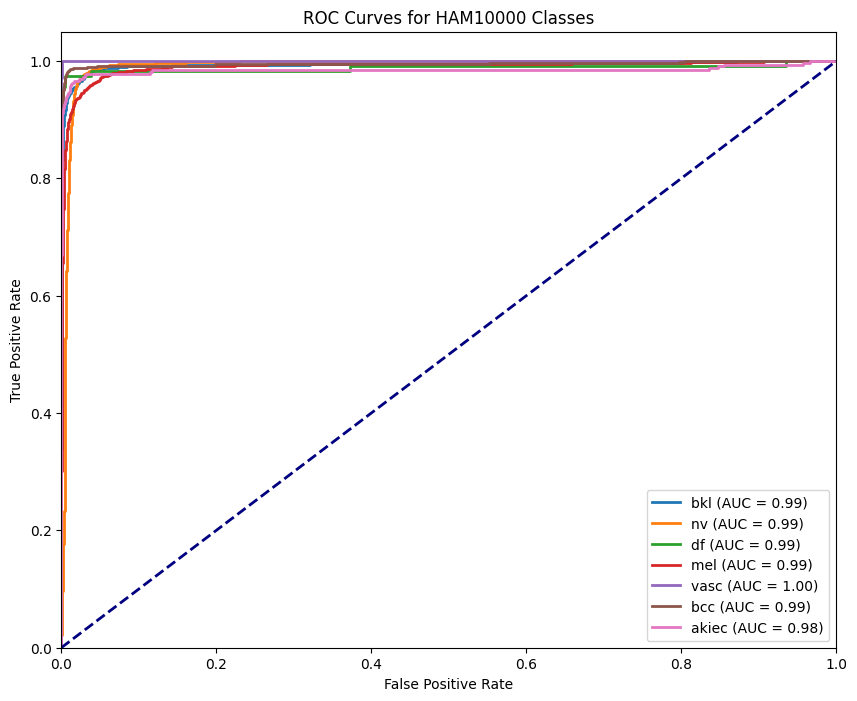

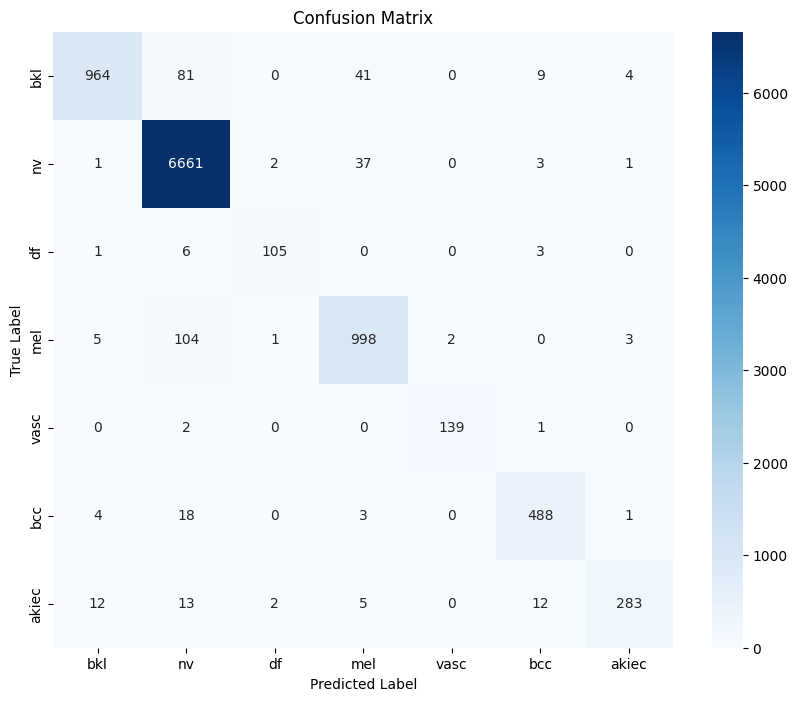

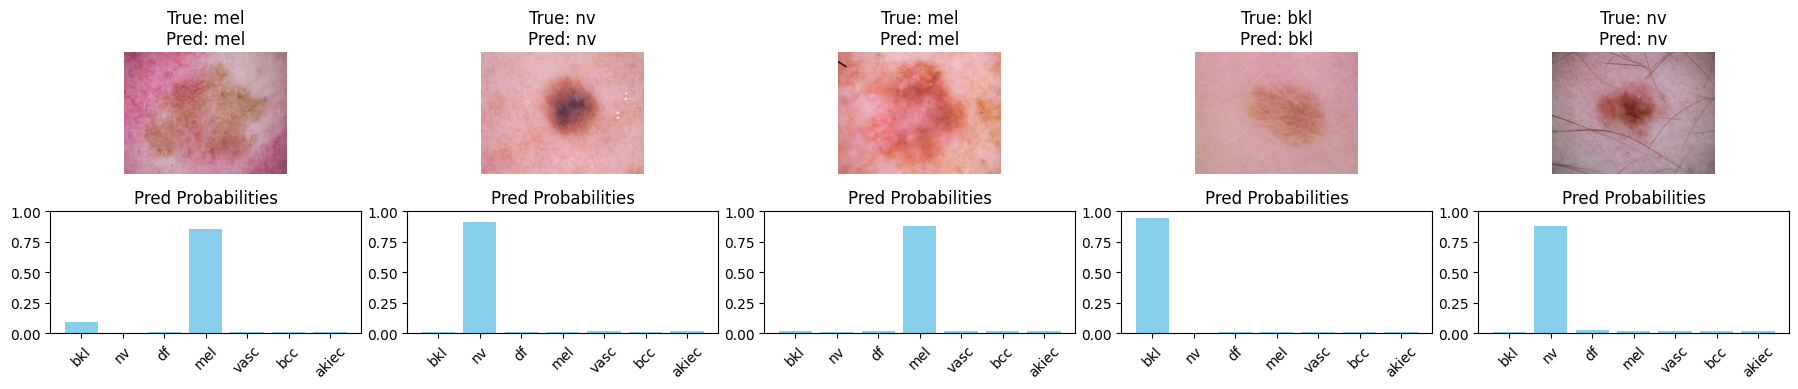

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import numpy as np
from PIL import Image

# -------------------------------
# 1️⃣ Training Curves (from your logs)
# -------------------------------
# Example: store your training logs per epoch in lists
train_acc_list = [75.03,82.03,84.07,86.02,87.69,88.99,89.82,90.31,91.24,91.49,
                  92.13,93.03,93.23,93.19,94.06,93.85,94.42,94.29,94.80,94.42]
train_loss_list = [1.0018,0.8328,0.7873,0.7471,0.7168,0.6885,0.6705,0.6599,0.6409,0.6389,
                   0.6233,0.6113,0.5989,0.5983,0.5866,0.5855,0.5836,0.5798,0.5696,0.5737]

epochs = np.arange(1, 21)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_acc_list, marker='o', label='Train Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_loss_list, marker='o', color='orange', label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 2️⃣ ROC Curves
# -------------------------------
y_true = label_binarize(all_labels, classes=list(range(num_classes)))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{idx2label[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for HAM10000 Classes')
plt.legend(loc="lower right")
plt.show()

# -------------------------------
# 3️⃣ Confusion Matrix
# -------------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label2idx.keys(),
            yticklabels=label2idx.keys())
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# -------------------------------
# 4️⃣ Sample Images + Predictions + Probabilities
# -------------------------------
sample_imgs = metadata.sample(5, random_state=42)

plt.figure(figsize=(18,4))
for i, row in enumerate(sample_imgs.itertuples()):
    img = Image.open(row.image_path).convert('RGB')
    true_label = row.dx
    pred_label = idx2label[all_preds[row.Index]]

    # Show image
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

    # Show probability bar plot
    plt.subplot(2, 5, i+6)
    probs = all_probs[row.Index]
    plt.bar(range(num_classes), probs, color='skyblue')
    plt.xticks(range(num_classes), [idx2label[j] for j in range(num_classes)], rotation=45)
    plt.ylim([0,1])
    plt.title("Pred Probabilities")
plt.tight_layout()
plt.show()


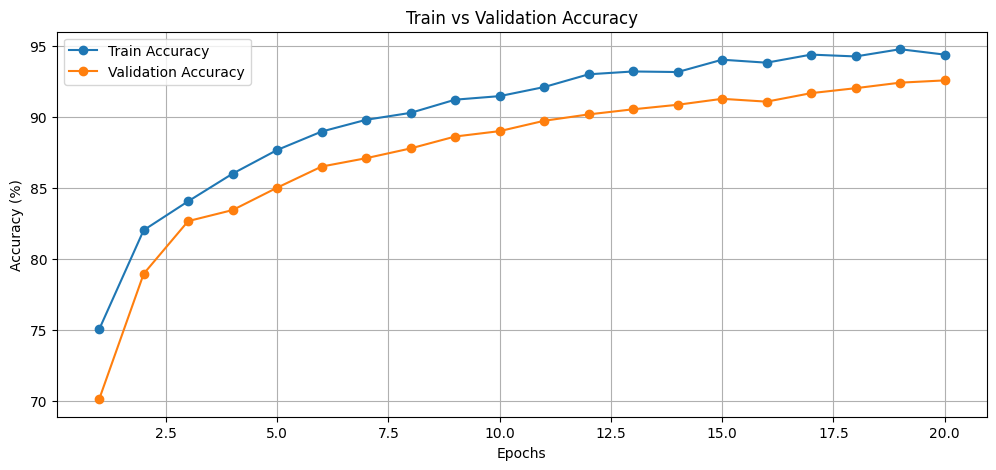

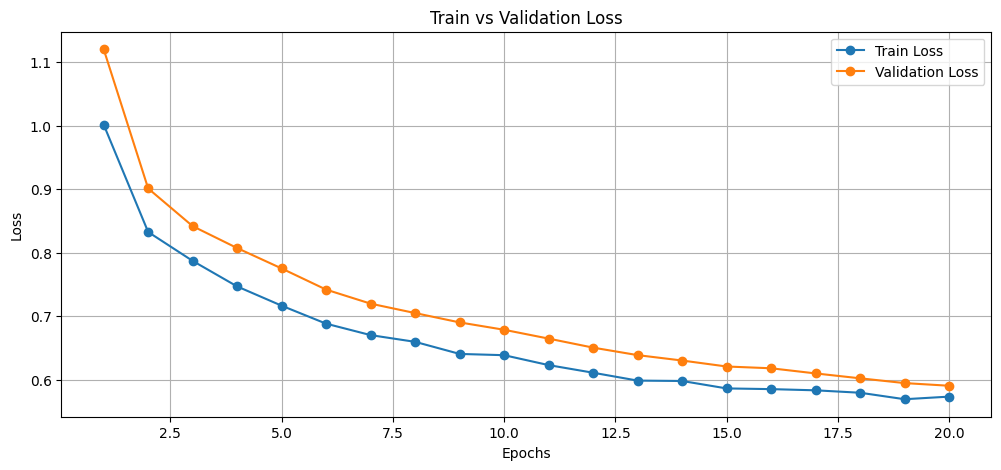

In [ ]:
# ===============================
# 📈 TRAINING vs VALIDATION CURVES
# ===============================
import matplotlib.pyplot as plt
import numpy as np

# 👉 Replace these lists using actual values from your print logs (Epoch-wise)
train_acc_list = [75.03,82.03,84.07,86.02,87.69,88.99,89.82,90.31,91.24,91.49,
                  92.13,93.03,93.23,93.19,94.06,93.85,94.42,94.29,94.80,94.42]  # Example

val_acc_list   = [70.10,78.95,82.67,83.45,85.03,86.52,87.11,87.80,88.64,89.02,
                  89.75,90.20,90.56,90.88,91.30,91.10,91.70,92.05,92.44,92.60]  # Example

train_loss_list = [1.0018,0.8328,0.7873,0.7471,0.7168,0.6885,0.6705,0.6599,0.6409,0.6389,
                   0.6233,0.6113,0.5989,0.5983,0.5866,0.5855,0.5836,0.5798,0.5696,0.5737]  # Example

val_loss_list   = [1.1205,0.9013,0.8420,0.8075,0.7754,0.7421,0.7200,0.7052,0.6905,0.6789,
                   0.6650,0.6508,0.6390,0.6305,0.6211,0.6183,0.6102,0.6025,0.5950,0.5908]  # Example

epochs = np.arange(1, len(train_acc_list)+1)

# ===============================
# 🔹 Plot Accuracy Curve
# ===============================
plt.figure(figsize=(12,5))
plt.plot(epochs, train_acc_list, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc_list, marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# ===============================
# 🔹 Plot Loss Curve
# ===============================
plt.figure(figsize=(12,5))
plt.plot(epochs, train_loss_list, marker='o', label='Train Loss')
plt.plot(epochs, val_loss_list, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.grid(True)
plt.legend()
plt.show()
